In [1]:
#Installing the XGBoost package
!pip install xgboost

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 30.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing necessary libraries
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from openpyxl import load_workbook

In [3]:
#Reading the excel-document into a df
df = pd.read_excel('dataset_name.xlsx')

#dropping unwanted columns from the df
df2=df.drop(columns = ["Column 1", "Column 2"])

In [4]:
#Splitting df into two based on ID
df2["ID"] = df2["ID"].astype(str)  #Making sure its a string
df_train = df2[df2["ID"].isin(["ID 1", "ID 2", "ID 3"])]
df_unseen = df2[df2["ID"] == "ID 4"]


In [5]:
#Preparing PCA input by defining the columns to include in the transformation
columns = ['Column 1', 'Column 2', 'Column 3', 'Column 4', 'Column 5']

#Extracting and copying the selected columns from the training dataframe
data_train = df_train[columns].copy()

#Encoding 'ID' 
data_train['ID'] = data_train['ID'].astype('Category_column').cat.codes

#Initializing a standard scaler to normalize the data
scaler_pca = StandardScaler()

#Fitting the scaler on training data and apply the transformation
data_train_scaled = scaler_pca.fit_transform(data_train)

#Initializing PCA to reduce dimensionality to 4 PCs
pca = PCA(n_components=4)

#Fitting PCA on the scaled training data and transforming it
pca_train = pca.fit_transform(data_train_scaled)

#Adding the first 4 principal components (PC1 to PC4) as new columns to df_train
for i in range(4):
    df_train.loc[:, f'PC{i+1}'] = pca_train[:, i]


#Applying the same PCA transformation to the unseen dataset 

#Extracting and copying the same columns from the unseen dataset
data_unseen = df_unseen[columns].copy()

#Encode 'ID' 
data_unseen['ID'] = data_unseen['ID'].astype('Category_column').cat.codes

#Applying the same scaling 
data_unseen_scaled = scaler_pca.transform(data_unseen)

#Applying the same PCA transformation
pca_unseen = pca.transform(data_unseen_scaled)

#Adding PC1 to PC4 as new columns to df_unseen
for i in range(4):
    df_unseen.loc[:, f'PC{i+1}'] = pca_unseen[:, i]

In [6]:
#Preparing inputs and target values
X = df_train[['PC1', 'PC2', 'PC3', 'PC4']]
y = df_train['Category_column']

X_unseen = df_unseen[['PC1', 'PC2', 'PC3', 'PC4']]
y_unseen = df_unseen['Category_column']


10

In [7]:
#Setting up K-Fold cross-validation with 10 splits
k_fold = KFold(n_splits=10, random_state=66, shuffle=True)

#Initializing the XGBoost classifier 
XGB = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss")

#Extract the train and test from the k-fold
train_index, test_index = next(k_fold.split(X, y))

#Splitting the data into training and test sets 
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#Making surethe class labels start from 0, which is required for XGBoost with 'multi:softmax'
y_train_fixed = y_train - y_train.min()
y_test_fixed = y_test - y_test.min()

In [8]:
#Initializing a StandardScaler to normalize features
scaler = StandardScaler()

#Fitting the scaler on the training data and applying the transformation
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

In [9]:
#Defining the hyperparameter grid to search for the optimal hyperparameters
param_grid = {
    'n_estimators': [350],                  
    'max_depth': [2, 3, 4],                 
    'learning_rate': [0.01, 0.1],           
    'subsample': [0.5, 0.7],               
    'colsample_bytree': [0.9],             
    'reg_alpha': [0.1, 1, 5, 10],           
    'reg_lambda': [15]}

#Initializing GridSearchCV to search over the parameter grid 
CV_XGB = GridSearchCV(
    estimator=XGB,              
    param_grid=param_grid,       
    cv=k_fold,                 
    scoring='f1_weighted',       
    n_jobs=-1,               
    verbose=1                   
)

#Fitting the grid search using the scaled training data 
CV_XGB.fit(X_train_scaled, y_train_fixed)

#Printing the best hyperparameter combination 
print('Best Parameters: ', CV_XGB.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 350, 'reg_alpha': 0.1, 'reg_lambda': 15, 'subsample': 0.7}


In [10]:
#Getting the best XGBoost model found by GridSearchCV
XGB_best = CV_XGB.best_estimator_

#Saving the best hyperparameters found
best_params = CV_XGB.best_params_

#Making predictions on the scaled training data
pred_train = XGB_best.predict(X_train_scaled)

# Make predictions on the scaled test data
pred_test = XGB_best.predict(X_test_scaled)

Train Accuracy: 1.0000
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000


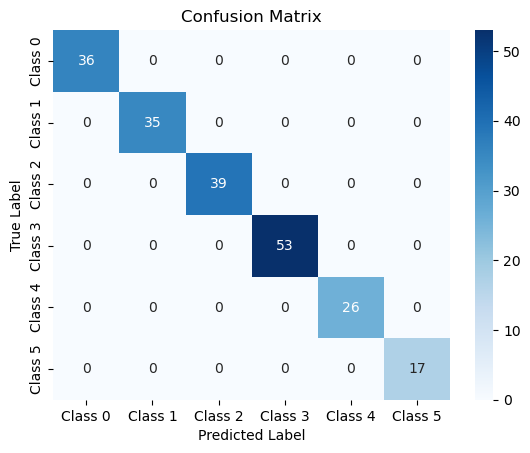

In [11]:
#Calculating performance metrics for the train data
acc_train = accuracy_score(y_train_fixed, pred_train)
precision_train = precision_score(y_train_fixed, pred_train, average='weighted')
recall_train = recall_score(y_train_fixed, pred_train, average='weighted')
f1_train = f1_score(y_train_fixed, pred_train, average='weighted')

#Printing the evaluation metrics
print(f'Train Accuracy: {acc_train:.4f}')
print(f'Train Precision: {precision_train:.4f}')
print(f'Train Recall: {recall_train:.4f}')
print(f'Train F1 Score: {f1_train:.4f}')

#Generating the confusion matrix 
cm = confusion_matrix(y_train_fixed, pred_train)

#Creating readable class labels based on y_train
class_labels = [f"Class {i}" for i in np.unique(y_train_fixed)]

#Visualizing the confusion matrix 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 0.5652
Test Precision: 0.6696
Test Recall: 0.5652
Test F1 Score: 0.5487


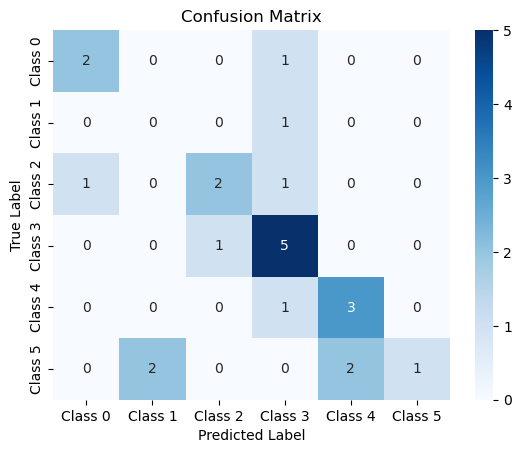

In [12]:
#Calculating performance metrics for the test data
acc_test = accuracy_score(y_test_fixed, pred_test)
precision_test = precision_score(y_test_fixed, pred_test, average='weighted')
recall_test = recall_score(y_test_fixed, pred_test, average='weighted')
f1_test = f1_score(y_test_fixed, pred_test, average='weighted')

#Printing evaluation metrics
print(f'Test Accuracy: {acc_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')

#Generating confusion matrix to compare predicted VS true classes
cm = confusion_matrix(y_test_fixed, pred_test)

#Creating class labels based on y_test
class_labels = [f"Class {i}" for i in np.unique(y_test_fixed)]

#Visualizing the confusion matrix as a heatmap
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Unseen Accuracy: 0.1613
Unseen Precision: 0.1158
Unseen Recall: 0.1613
Unseen F1 Score: 0.1348


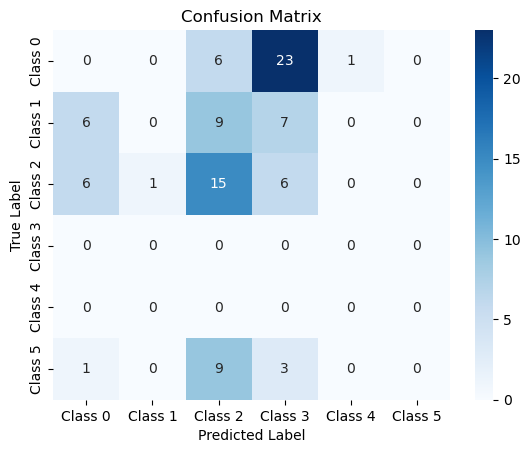

Confusion Matrix:
 [[ 0  0  6 23  1  0]
 [ 6  0  9  7  0  0]
 [ 6  1 15  6  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  9  3  0  0]]


In [13]:
#Adjusting unseen target to start from 0 (same as training labels)
y_unseen_fixed = y_unseen - y_train.min()

#Scaling the unseen input features using the same scaler fitted on training data
X_unseen_scaled = scaler.transform(X_unseen)


#Making predictions on the unseen data
y_pred_unseen = XGB_best.predict(X_unseen_scaled)

#Calculating performance metrics for the unseen data
acc_unseen = accuracy_score(y_unseen_fixed, y_pred_unseen)
precision_unseen = precision_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)
recall_unseen = recall_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)
f1_unseen = f1_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)

#Printing the evaluation results for unseen data
print(f'Unseen Accuracy: {acc_unseen:.4f}')
print(f'Unseen Precision: {precision_unseen:.4f}')
print(f'Unseen Recall: {recall_unseen:.4f}')
print(f'Unseen F1 Score: {f1_unseen:.4f}')

#Generate confusion matrix
cm_unseen = confusion_matrix(y_unseen_fixed, y_pred_unseen)

#Combining true and predicted labels to ensure all classes are included in the matrix labels
all_labels = np.unique(np.concatenate((y_unseen_fixed, y_pred_unseen)))

#Generating readable laberls
class_labels = [f"Class {i}" for i in all_labels]

#Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [14]:
#Defining a function to log model evaluation metrics and hyperparameters to an Excel-file of chosen name
def log_results(model_name, params, accuracy_train, precision_train, recall_train, f1_train,
                accuracy_test, precision_test, recall_test, f1_test,
                accuracy_unseen, precision_unseen, recall_unseen, f1_unseen,
                filename="Results.xlsx"):
    """ Logs classification model results in separate sheets within the same Excel file, ensuring appending works correctly. """

    # Creating DataFrame for this model run
    result = pd.DataFrame([{
        **params, 
        "Accuracy_Train": accuracy_train,
        "Precision_Train": precision_train,
        "Recall_Train": recall_train,
        "F1_Train": f1_train,
        "Accuracy_Test": accuracy_test,
        "Precision_Test": precision_test,
        "Recall_Test": recall_test,
        "F1_Test": f1_test,
        "Accuracy_Unseen": accuracy_unseen,
        "Precision_Unseen": precision_unseen,
        "Recall_Unseen": recall_unseen,
        "F1_Unseen": f1_unseen}])

    #Introducing a short delay to avoid file conflicts if running in multiple notebooks
    time.sleep(1)

    #Checking if the file exists
    file_exists = os.path.exists(filename)

    if not file_exists:
        #If file doesn't exist, creating a new one
        with pd.ExcelWriter(filename, engine="openpyxl", mode="w") as writer:
            result.to_excel(writer, sheet_name=model_name, index=False)
    else:
        #If file exists, loading it before appending
        try:
            with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
                #Reading existing sheet 
                try:
                    existing_df = pd.read_excel(filename, sheet_name=model_name, engine="openpyxl")
                    df_combined = pd.concat([existing_df, result], ignore_index=True)
                except (FileNotFoundError, ValueError):
                    df_combined = result  #If sheet does not exist, creating it

                #Saving results, ensuring correct appending
                df_combined.to_excel(writer, sheet_name=model_name, index=False)

        except PermissionError:
            #Printing error to warn user
            print(f"Error: Close the Excel file ({filename}) before running the script again.")

    #Printing a confirmation to ensure user results are logged
    print(f"Logged results for {model_name}: Train Accuracy={accuracy_train:.4f}, Test Accuracy={accuracy_test:.4f}, Unseen Accuracy={accuracy_unseen:.4f}")



In [15]:
#Using the function to log results from XGBC model
log_results(
    model_name="XGB-class_PCA",
    params=best_params,

    accuracy_train=acc_train,
    precision_train=precision_train,
    recall_train=recall_train,
    f1_train=f1_train,

    accuracy_test=acc_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1_test=f1_test,

    accuracy_unseen=acc_unseen,
    precision_unseen=precision_unseen,
    recall_unseen=recall_unseen,
    f1_unseen=f1_unseen
)


✅ Logged results for XGB-Kfold_cleaned: Train Accuracy=1.0000, Test Accuracy=0.5652, Unseen Accuracy=0.1613
